In [1]:
# Initial imports
import os
import pandas as pd
from newsapi import NewsApiClient
from dotenv import load_dotenv
load_dotenv('config.py.txt')
from pathlib import Path
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
from pandas import json_normalize
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

from nltk.corpus import stopwords, reuters
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt

import numpy as np


import nltk
nltk.download('wordnet')
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')


lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cliffordcharles/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /Users/cliffordcharles/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cliffordcharles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cliffordcharles/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:

api_key = os.getenv('NEWS_API_KEY')

# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [3]:
XRP_headlines = newsapi.get_top_headlines(q="xrp", language="en", country="us")
XRP_headlines

{'status': 'ok', 'totalResults': 0, 'articles': []}

In [4]:
#print(f"Total articles about XRP: {XRP_headlines['totalResults']}")

# Show sample article
#XRP_headlines["articles"][0]

In [5]:
#XRP_df = pd.DataFrame.from_dict(XRP_headlines["articles"])

#XRP_df.head()

In [6]:
XRP_headlines_everything = newsapi.get_everything(
    q="XRP", language="en", sort_by="relevancy"
)

# Print total articles
print(f"Total articles about XRP: {XRP_headlines_everything['totalResults']}")

# Show sample article
XRP_headlines_everything["articles"][0]

Total articles about XRP: 460


{'source': {'id': None, 'name': 'Motley Fool'},
 'author': 'newsfeedback@fool.com (Keith Noonan)',
 'title': 'Why XRP (Ripple) Is Soaring Today',
 'description': "The cryptocurrency is making big gains following positive news about Ripple's defense in the SEC lawsuit.",
 'url': 'https://www.fool.com/investing/2022/03/12/why-xrp-is-soaring-today/',
 'urlToImage': 'https://g.foolcdn.com/editorial/images/670282/an-xrp-token-logo.jpg',
 'publishedAt': '2022-03-12T19:23:45Z',
 'content': "What happened\r\nRipple's XRP( XRP -1.34% ) token is making big gains in Saturday's trading. The digital token's price was up roughly 8.3% over the previous 24-hour period as of noon ET Saturday. \r\nXRP… [+1945 chars]"}

In [7]:
XRP_df = pd.DataFrame.from_dict(XRP_headlines_everything["articles"])
XRP_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Motley Fool'}",newsfeedback@fool.com (Keith Noonan),Why XRP (Ripple) Is Soaring Today,The cryptocurrency is making big gains followi...,https://www.fool.com/investing/2022/03/12/why-...,https://g.foolcdn.com/editorial/images/670282/...,2022-03-12T19:23:45Z,What happened\r\nRipple's XRP( XRP -1.34% ) to...
1,"{'id': None, 'name': 'Motley Fool'}",newsfeedback@fool.com (Chris MacDonald),"Why XRP, Cardano, and Polkadot Are Surging Hig...","The crypto market is surging, but these three ...",https://www.fool.com/investing/2022/03/28/why-...,https://g.foolcdn.com/editorial/images/672278/...,2022-03-28T17:18:27Z,What happened\r\nToday's surge in valuations a...
2,"{'id': None, 'name': 'Forbes'}","John Navin, Contributor, \n John Navin, Contri...",Big Cryptocurrencies Hold Price Support Levels...,"Bitcoin, Ethereum and XRP managed to hold abov...",https://www.forbes.com/sites/johnnavin/2022/03...,https://imageio.forbes.com/specials-images/ima...,2022-03-27T14:24:18Z,"Montreal, Canada - 28 February 2018: Stacked c..."
3,"{'id': None, 'name': 'Forbes'}","Billy Bambrough, Senior Contributor, \n Billy ...",The Price Of Ripple’s XRP Is Suddenly Surging ...,"XRP, the payments cryptocurrency developed by ...",https://www.forbes.com/sites/billybambrough/20...,https://imageio.forbes.com/specials-images/ima...,2022-03-12T16:15:11Z,"XRP, the payments cryptocurrency developed by ..."
4,"{'id': None, 'name': 'Forbes'}","Billy Bambrough, Senior Contributor, \n Billy ...",$2 Trillion Crypto Crash Warning: Sudden Shock...,"Bitcoin and major cryptocurrencies, including ...",https://www.forbes.com/sites/billybambrough/20...,https://imageio.forbes.com/specials-images/ima...,2022-04-07T01:30:07Z,Bitcoin and major cryptocurrenciesincluding et...


# Sentiment Analysis #

In [8]:
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/cliffordcharles/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
XRP_sentiments = []

for article in XRP_headlines_everything["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        XRP_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
XRP_df_sentiment = pd.DataFrame(XRP_sentiments)

# Reorder DataFrame columns
#cols = ["date", "text", "compound", "positive", "negative", "neutral"]
#XRP_df_sentiment = XRP_sentiments[cols]

XRP_df_sentiment.head()



,text,date,compound,positive,negative,neutral
0,What happened\r\nRipple's XRP( XRP -1.34% ) to...,2022-03-12,0.3400,0.066,0.000,0.934
1,What happened\r\nToday's surge in valuations a...,2022-03-28,0.7717,0.240,0.051,0.709
2,"Montreal, Canada - 28 February 2018: Stacked c...",2022-03-27,0.4019,0.085,0.000,0.915
3,"XRP, the payments cryptocurrency developed by ...",2022-03-12,0.0000,0.000,0.000,1.000
4,Bitcoin and major cryptocurrenciesincluding et...,2022-04-07,-0.2960,0.000,0.075,0.925


In [10]:
XRP_df_sentiment.describe()

,compound,positive,negative,neutral
count,20.000000,20.000000,20.000000,20.000000
mean,0.137455,0.069250,0.044100,0.886700
std,0.377605,0.059211,0.066867,0.081744
min,-0.743000,0.000000,0.000000,0.709000
25%,0.000000,0.037500,0.000000,0.863000
50%,0.202100,0.067500,0.000000,0.901000
75%,0.401900,0.088000,0.059750,0.934750
max,0.771700,0.240000,0.247000,1.000000


<AxesSubplot:>

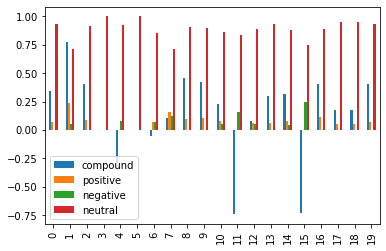

In [11]:
XRP_df_sentiment.plot(kind='bar')

# WordCloud: Prominence of frequent words

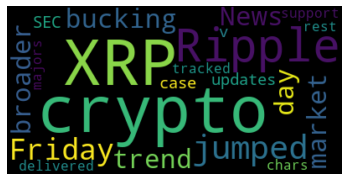

In [12]:
text_1 = XRP_df_sentiment.text[0]

# Create and generate a word cloud image:
wordcloud_sample_1 = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud_sample_1, interpolation='bilinear')
plt.axis("off")
plt.show()

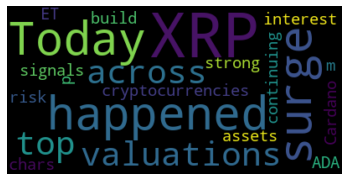

In [13]:
text_2 = XRP_df_sentiment.text[1]

# Create and generate a word cloud image:
wordcloud_sample_2 = WordCloud().generate(text_2)

# Display the generated image:
plt.imshow(wordcloud_sample_2, interpolation='bilinear')
plt.axis("off")
plt.show()

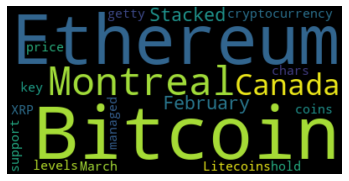

In [14]:
text_3 = XRP_df_sentiment.text[2]

# Create and generate a word cloud image:
wordcloud_sample_3 = WordCloud().generate(text_3)

# Display the generated image:
plt.imshow(wordcloud_sample_3, interpolation='bilinear')
plt.axis("off")
plt.show()

# Common words and themes between the articles

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer




In [62]:
text_4=XRP_df_sentiment.text[3]
text_5=XRP_df_sentiment.text[4]
text_6=XRP_df_sentiment.text[5]
text_7=XRP_df_sentiment.text[6]
text_8=XRP_df_sentiment.text[7]
text_9=XRP_df_sentiment.text[8]
text_10=XRP_df_sentiment.text[9]
text_11=XRP_df_sentiment.text[10]
text_12=XRP_df_sentiment.text[11]
text_13=XRP_df_sentiment.text[12]
text_14=XRP_df_sentiment.text[13]
text_15=XRP_df_sentiment.text[14]
text_16=XRP_df_sentiment.text[15]
text_17=XRP_df_sentiment.text[16]
text_18=XRP_df_sentiment.text[17]
text_19=XRP_df_sentiment.text[18]
text_20=XRP_df_sentiment.text[19]


In [63]:
bagofwords1= text_1.split(' ')
bagofwords2=text_2.split(' ')
bagofwords3=text_3.split(' ')
bagofwords4=text_4.split(' ')
bagofwords5=text_5.split(' ')
bagofwords6=text_6.split(' ')
bagofwords7=text_7.split(' ')
bagofwords8=text_8.split(' ')
bagofwords9=text_9.split(' ')
bagofwords10=text_10.split(' ')
bagofwords11=text_11.split(' ')
bagofwords12=text_12.split(' ')
bagofwords13=text_13.split(' ')
bagofwords14= text_14.split(' ')
bagofwords15= text_15.split(' ')
bagofwords16= text_16.split(' ')
bagofwords17= text_17.split(' ')
bagofwords18= text_18.split(' ')
bagofwords19= text_19.split(' ')
bagofwords20= text_20.split(' ')

In [71]:
uniqueWords = set(bagofwords1).union(set(bagofwords2)).union(set(bagofwords3)).union(set(bagofwords4)).union(set(bagofwords5)).union(set(bagofwords6)).union(set(bagofwords7)).union(set(bagofwords8)).union(set(bagofwords9)).union(set(bagofwords10)).union(set(bagofwords11)).union(set(bagofwords12)).union(set(bagofwords13)).union(set(bagofwords14)).union(set(bagofwords15)).union(set(bagofwords16)).union(set(bagofwords17)).union(set(bagofwords18)).union(set(bagofwords19)).union(set(bagofwords20))


In [72]:
numofwords1 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords1:
    numofwords1[word] += 1
numofwords2 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords2:
    numofwords2[word] += 1
numofwords3 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords3:
    numofwords3[word] += 1
numofwords4 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords4:
    numofwords4[word] += 1
numofwords5 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords5:
    numofwords5[word] += 1
numofwords6 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords6:
    numofwords6[word] += 1
numofwords7 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords7:
    numofwords7[word] += 1
numofwords8 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords8:
    numofwords8[word] += 1
numofwords9 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords9:
    numofwords9[word] += 1
numofwords10 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords10:
    numofwords10[word] += 1
numofwords11 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords11:
    numofwords11[word] += 1
numofwords12 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords12:
    numofwords12[word] += 1
numofwords13 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords13:
    numofwords13[word] += 1
numofwords14 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords14:
    numofwords14[word] += 1
numofwords15 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords15:
    numofwords15[word] += 1
numofwords16 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords16:
    numofwords16[word] += 1
numofwords17 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords17:
    numofwords17[word] += 1
numofwords18 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords18:
    numofwords18[word] += 1
numofwords19 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords19:
    numofwords19[word] += 1
numofwords20 = dict.fromkeys(uniqueWords, 0)
for word in bagofwords20:
    numofwords20[word] += 1

In [73]:
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [74]:
def computeTF(worddict, bagofwords):
    tfDict = {}
    bagofwordscount = len(bagofwords)
    for word, count in worddict.items():
        tfDict[word] = count / float(bagofwordscount)
    return tfDict

In [75]:
tf1 = computeTF(numofwords1, bagofwords1)
tf2 = computeTF(numofwords2, bagofwords2)
tf3 = computeTF(numofwords3, bagofwords3)
tf4 = computeTF(numofwords4, bagofwords4)
tf5 = computeTF(numofwords5, bagofwords5)
tf6 = computeTF(numofwords6, bagofwords6)
tf7 = computeTF(numofwords7, bagofwords7)
tf8 = computeTF(numofwords8, bagofwords8)
tf9 = computeTF(numofwords9, bagofwords9)
tf10 = computeTF(numofwords10, bagofwords10)
tf11 = computeTF(numofwords11, bagofwords11)
tf12 = computeTF(numofwords12, bagofwords12)
tf13 = computeTF(numofwords13, bagofwords13)
tf14 = computeTF(numofwords14, bagofwords14)
tf15 = computeTF(numofwords15, bagofwords15)
tf16 = computeTF(numofwords16, bagofwords16)
tf17 = computeTF(numofwords17, bagofwords17)
tf18 = computeTF(numofwords18, bagofwords18)
tf19 = computeTF(numofwords19, bagofwords19)
tf20 = computeTF(numofwords20, bagofwords20)


In [76]:
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict


In [77]:
idfs = computeIDF([numofwords1, numofwords2, numofwords3, numofwords4, numofwords5, numofwords6, numofwords7, numofwords8, numofwords9, numofwords10, numofwords11, numofwords12, numofwords13, numofwords14, numofwords15, numofwords16, numofwords17, numofwords18, numofwords19, numofwords20])

In [78]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [80]:
tfidf1 = computeTFIDF(tf1, idfs)
tfidf2 = computeTFIDF(tf2, idfs)
tfidf3 = computeTFIDF(tf3, idfs)
tfidf4 = computeTFIDF(tf4, idfs)
tfidf5 = computeTFIDF(tf5, idfs)
tfidf6 = computeTFIDF(tf6, idfs)
tfidf7 = computeTFIDF(tf7, idfs)
tfidf8 = computeTFIDF(tf8, idfs)
tfidf9 = computeTFIDF(tf9, idfs)
tfidf10 = computeTFIDF(tf10, idfs)
tfidf11 = computeTFIDF(tf11, idfs)
tfidf12 = computeTFIDF(tf12, idfs)
tfidf13 = computeTFIDF(tf13, idfs)
tfidf14 = computeTFIDF(tf14, idfs)
tfidf15 = computeTFIDF(tf15, idfs)
tfidf16 = computeTFIDF(tf16, idfs)
tfidf17 = computeTFIDF(tf17, idfs)
tfidf18 = computeTFIDF(tf18, idfs)
tfidf19 = computeTFIDF(tf19, idfs)
tfidf20 = computeTFIDF(tf20, idfs)

df = pd.DataFrame([tfidf1, tfidf2, tfidf3, tfidf4, tfidf5, tfidf6, tfidf7, tfidf8, tfidf9, tfidf10, tfidf11, tfidf12, tfidf13, tfidf14, tfidf15, tfidf16, tfidf17, tfidf18, tfidf19, tfidf20])

In [85]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([text_1, text_2, text_3, text_4, text_5, text_6, text_7, text_8, text_9, text_10, text_11, text_12, text_13, text_14, text_15, text_16, text_17, text_18, text_19, text_20])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

/Users/cliffordcharles/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [88]:
df_t=df.T
df_t.to_csv('df.csv')
df_t


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.193364,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000
02,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.185264
10,0.000000,0.201996,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000
12,0.000000,0.201996,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000
154,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.1896,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
white,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.165873,0.0000,0.0,0.0,0.179247,0.0,0.0,0.000000
wiping,0.000000,0.000000,0.00000,0.000000,0.218407,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000
with,0.000000,0.160218,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.169674,0.0,0.000000,0.000000,0.149674,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000
xrp,0.326095,0.236881,0.12074,0.138277,0.128063,0.0,0.000000,0.0,0.000000,0.0,0.238244,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.217260


### The following df is the tf-idf df but with manual changes applied ###

### The columns that are dropped are the stopwords, words that appear once in an arrticle but not in others, or numbers that are not needed

In [90]:
read=Path('df.csv')
df_updated=pd.read_csv(read)
df_updated

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,assets,0.000000,0.146769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170084,0.170084,0.000000
1,bitcoin,0.000000,0.000000,0.257890,0.147673,0.136765,0.000000,0.242167,0.000000,0.133954,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.139148,0.000000,0.000000,0.000000,0.000000
2,chars,0.055315,0.060273,0.061443,0.070367,0.065169,0.059378,0.057697,0.056635,0.063830,...,0.060619,0.056418,0.056306,0.056574,0.063165,0.066305,0.060846,0.069847,0.069847,0.055280
3,crypto,0.000000,0.000000,0.000000,0.000000,0.146811,0.133764,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.126844,0.127447,0.000000,0.000000,0.000000,0.000000,0.000000,0.249066
4,cryptocurrency,0.000000,0.000000,0.107030,0.122575,0.000000,0.000000,0.100504,0.098655,0.111188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.115499,0.105990,0.121670,0.121670,0.000000
5,digital,0.116085,0.000000,0.000000,0.000000,0.000000,0.124611,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127692,0.146583,0.146583,0.000000
6,ethereum,0.000000,0.000000,0.326659,0.187052,0.173235,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,getty,0.000000,0.000000,0.163329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.161140,0.000000,0.000000,0.000000,0.167908,0.000000,0.000000,0.000000,0.000000,0.000000
8,major,0.000000,0.000000,0.000000,0.171350,0.158693,0.144590,0.140497,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,market,0.000000,0.000000,0.000000,0.000000,0.000000,0.133764,0.000000,0.127586,0.000000,...,0.136561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124533


In [12]:
from textblob import TextBlob
import tweepy
import sys
import configparser

In [13]:
mykeys = open('config.py.txt', 'r').read().splitlines()

In [14]:
api_key= mykeys[9]
secret_api_key = mykeys[10]
access_token= mykeys[12]
access_token_secret= [13]

In [15]:
auth_handler = tweepy.OAuthHandler(consumer_key=api_key,consumer_secret=secret_api_key)

In [16]:
auth_handler.set_access_token(access_token, access_token_secret)

In [17]:
api=tweepy.API(auth_handler)


In [18]:
search_term = 'xrp'
user= 'XRPNews_'
keywords='2022'
tweet_amount= 200
limit=100
#tweets = tweepy.Cursor(api.search_tweets,q= search_term, lang= 'en').items(tweet_amount)

In [19]:
# Account
tweets = api.user_timeline(screen_name= user,
                           count=limit, tweet_mode='extended')
columss=['User','Tweet']
data=[]
for tweet in tweets:
    data.append([tweets.user.screen_name, tweet.full_text])
df_tweet=pd.DataFrame(data, columns=columnss)
print(df_tweet)
    

TweepyException: Failed to send request: Only unicode objects are escapable. Got [13] of type <class 'list'>.

In [10]:
# Hashtag
tweets= tweepy.Cursor(api.search_tweets,
                      q=search_term, count=100,
                      tweet_mode='extended').items(tweet_amount)
for tweet in tweets:
    print(tweet)

TweepyException: Failed to send request: Only unicode objects are escapable. Got [13] of type <class 'list'>.

In [20]:
#polarity=0

#for tweet in tweets:
    #final_text = tweet.text.replace('RT', '')
    #if final_text.startswith('@'):
        #position =final_text.index(':')
        #final_text = final_text[position+2:]
        #if final_text.startswith('@'):
            #position =final_text.index(' ')
        #final_text = final_text[position+2:]
        #analysis=TextBlob(final_text)
        #polarity += analysis.polarity
    